In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import json

In [ ]:
plt.rc('font', family='NanumBarunGothic')

In [ ]:
train = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/modeling/subject_19.xlsx', engine='openpyxl')
val = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/modeling/subject_20.xlsx', engine='openpyxl')
inf = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/modeling/subject_21.xlsx', engine='openpyxl')

In [ ]:
train_data = train.copy()
val_data = val.copy()
inf_data = inf.copy()

In [ ]:
# 추가
inf_data = inf_data.drop(['2019_역량평가등급', '2019_업적평가등급', '2020_역량평가등급', '2020_업적평가등급'], axis=1)

In [ ]:
train_data = pd.concat([train_data, val_data, inf_data], axis=0)
train_data.reset_index(drop=True, inplace=True)
train_data_count = train_data.copy()

In [ ]:
random_seed = 1

In [ ]:
train_data['셀 참여횟수'] = train_data['셀 참여횟수'].fillna(0)
train_data['봉사활동 참여횟수'] = train_data['봉사활동 참여횟수'].fillna(0)
train_data['금년 평균 교육점수'] = train_data['금년 평균 교육점수'].replace('미신청', 0)
train_data = train_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책'], axis=1)

train_data['역량평가등급'].replace('S', 5, inplace=True)
train_data['역량평가등급'].replace('A', 4, inplace=True)
train_data['역량평가등급'].replace('B', 3, inplace=True)
train_data['역량평가등급'].replace('C', 2, inplace=True)
train_data['역량평가등급'].replace('D', 1, inplace=True)

train_data['업적평가등급'].replace('S', 5, inplace=True)
train_data['업적평가등급'].replace('A', 4, inplace=True)
train_data['업적평가등급'].replace('B', 3, inplace=True)
train_data['업적평가등급'].replace('C', 2, inplace=True)
train_data['업적평가등급'].replace('D', 1, inplace=True)

In [ ]:
idx = train_data[train_data['역량평가등급']=='미평가'].index
train_data.drop(idx, inplace=True)

In [ ]:
X = pd.get_dummies(train_data.drop(['사번', '역량평가등급', '업적평가등급'], axis=1), columns = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first = True)
X_temp = pd.get_dummies(train_data.drop(['역량평가등급', '업적평가등급'], axis=1), columns = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first = True)
y_f = train_data['역량평가등급']
y_s = train_data['업적평가등급']

size = 0.2 

X_train, X_test, y_train_f, y_test_f = train_test_split(X, y_f, test_size=size, random_state=random_seed)
X_train, X_test, y_train_s, y_test_s = train_test_split(X, y_s, test_size=size, random_state=random_seed)

In [ ]:
if ((set(X_train.columns)-set(X_test.columns)) != set()) :
  feature = list(set(X_train.columns)-set(X_test.columns))
  for i in range(len(feature)) : 
    X_test[feature[i]] = 0
if ((set(X_test.columns)-set(X_train.columns)) != set()) :
  feature = list(set(X_test.columns)-set(X_train.columns))
  for i in range(len(feature)) : 
    X_train[feature[i]] = 0 

X_test = X_test[X_train.columns]

In [ ]:
benchmark = pd.DataFrame(columns=['Algorithm', 'MAE', 'RMSE', 'MAPE', 'r2'])

for algorithm in [LinearRegression(), RandomForestRegressor(random_state=random_seed), XGBRegressor(random_state=random_seed),MLPRegressor(random_state=random_seed), Lasso(), Ridge(), GradientBoostingRegressor(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['regressor', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= 'neg_mean_absolute_error',
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_train, y_train_f)
    results_pred = results.predict(X_test)
    mae = mean_absolute_error(y_test_f, results_pred)
    rmse = mean_squared_error(y_test_f, results_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test_f, results_pred)
    r2_cof = r2_score(y_test_f, results_pred)
    benchmark = benchmark.append({'Algorithm' : algorithm, 'MAE' : mae,'RMSE' : rmse, 'MAPE' : mape, 'r2' : r2_cof}, ignore_index=True)

[02:20:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
benchmark

,Algorithm,MAE,RMSE,MAPE,r2
0,LinearRegression(),0.849609,1.031562,0.251772,-0.021604
1,RandomForestRegressor(random_state=1),0.600690,0.750246,0.179276,0.459620
2,XGBRegressor(random_state=1),0.669615,0.821717,0.207603,0.351759
3,MLPRegressor(random_state=1),12.797453,13.879022,3.794754,-183.930960
4,Lasso(),0.855410,1.046588,0.227292,-0.051583
5,Ridge(),0.780342,0.943674,0.230861,0.145059
6,GradientBoostingRegressor(random_state=1),0.661050,0.814993,0.206983,0.362325


In [ ]:
opt_dict_1 = {}
idx = benchmark['MAPE'].idxmin()
column_list = ['MAE', 'RMSE', 'MAPE', 'r2']
benchmark = benchmark.drop([idx], axis=0).reset_index(drop=True)

for columns in list(column_list) : 
  opt_dict_1['Average '+columns] = benchmark[columns].mean()

opt_dict_1  

{'Average MAE': 2.7689132728336214,
 'Average RMSE': 3.089592836251431,
 'Average MAPE': 0.8198774747072339,
 'Average r2': -30.524167433108857}

In [ ]:
benchmark_2 = pd.DataFrame(columns=['Algorithm', 'MAE', 'RMSE', 'MAPE', 'r2'])

for algorithm in [LinearRegression(), RandomForestRegressor(random_state=random_seed), XGBRegressor(random_state=random_seed),MLPRegressor(random_state=random_seed), Lasso(), Ridge(), GradientBoostingRegressor(random_state=random_seed)]:
    pipeline = Pipeline(steps = [['regressor', algorithm]])
    
    results = GridSearchCV(estimator=pipeline,
                           scoring= 'neg_mean_absolute_error',
                           param_grid ={},
                           cv = None,
                           n_jobs=-1)
    results.fit(X_train, y_train_s)
    results_pred = results.predict(X_test)
    mae = mean_absolute_error(y_test_s, results_pred)
    rmse = mean_squared_error(y_test_s, results_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test_s, results_pred)
    r2_cof = r2_score(y_test_s, results_pred)
    benchmark_2 = benchmark_2.append({'Algorithm' : algorithm, 'MAE' : mae,'RMSE' : rmse, 'MAPE' : mape, 'r2' : r2_cof}, ignore_index=True)

[02:20:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
benchmark_2

,Algorithm,MAE,RMSE,MAPE,r2
0,LinearRegression(),0.938670,1.249962,0.244755,-0.510324
1,RandomForestRegressor(random_state=1),0.978966,1.165589,0.252351,-0.313310
2,XGBRegressor(random_state=1),0.945302,1.132396,0.254756,-0.239578
3,MLPRegressor(random_state=1),12.846483,13.906859,3.513010,-185.954032
4,Lasso(),0.975190,1.080529,0.258642,-0.128626
5,Ridge(),0.899246,1.078476,0.235836,-0.124340
6,GradientBoostingRegressor(random_state=1),0.913591,1.122165,0.235725,-0.217279


In [ ]:
opt_dict_2 = {}
idx = benchmark_2['MAPE'].idxmin()
column_list = ['MAE', 'RMSE', 'MAPE', 'r2']
benchmark_2 = benchmark_2.drop([idx], axis=0).reset_index(drop=True)

for columns in list(column_list) : 
  opt_dict_2['Average '+columns] = benchmark_2[columns].mean()

opt_dict_2  

{'Average MAE': 2.9306425971130565,
 'Average RMSE': 3.268968498937983,
 'Average MAPE': 0.7932248974364015,
 'Average r2': -31.21170159319516}

In [ ]:
# rmse 로직 수정
# 2, 8
# 2, 49
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_temp, y_f, test_size=size, random_state=2)

train_name_f = X_train_f['사번']
X_train_f.drop(['사번'], axis=1, inplace=True)
X_test_f.drop(['사번'], axis=1, inplace=True)

model_rf_1 = RandomForestRegressor(n_estimators = 100, max_depth=10, min_samples_split=5, random_state = 49)

model_rf_1.fit(X_train_f, y_train_f)
pred_la = model_rf_1.predict(X_test_f)
now = datetime.now()
f_mae = mean_absolute_error(y_test_f, pred_la)
f_rmse = mean_squared_error(y_test_f, pred_la, squared=False)
f_mape = mean_absolute_percentage_error(y_test_f, pred_la)
f_r2_cof = r2_score(y_test_f, pred_la)

metrics_dict_1 = {}
metrics_dict_1['MAE'] = f_mae
metrics_dict_1['RMSE'] = f_rmse
metrics_dict_1['MAPE'] = f_mape
metrics_dict_1['r2_score'] = f_r2_cof

metrics_dict_1

{'MAE': 0.4227834251296431,
 'RMSE': 0.5301663729822016,
 'MAPE': 0.12204204346426724,
 'r2_score': 0.6716871692533783}

In [ ]:
# rmse 로직 수정
# 22, 49
# 22, 46
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_temp, y_s, test_size=size, random_state=22)

train_name_s = X_train_s['사번']
X_train_s.drop(['사번'], axis=1, inplace=True)
X_test_s.drop(['사번'], axis=1, inplace=True)

model_rf_2 = RandomForestRegressor(n_estimators = 100, max_depth=10, min_samples_split=5, random_state = 46)

model_rf_2.fit(X_train_s, y_train_s)
pred_xgb = model_rf_2.predict(X_test_s)

s_mae = mean_absolute_error(y_test_s, pred_xgb)
s_rmse = mean_squared_error(y_test_s, pred_xgb, squared=False)
s_mape = mean_absolute_percentage_error(y_test_s, pred_xgb)
s_r2_cof = r2_score(y_test_s, pred_xgb)

metrics_dict_2 = {}
metrics_dict_2['MAE'] = s_mae
metrics_dict_2['RMSE'] = s_rmse
metrics_dict_2['MAPE'] = s_mape
metrics_dict_2['r2_score'] = s_r2_cof

metrics_dict_2

{'MAE': 0.5659026295741516,
 'RMSE': 0.7020237420099674,
 'MAPE': 0.16291543533975164,
 'r2_score': 0.29270273347318343}

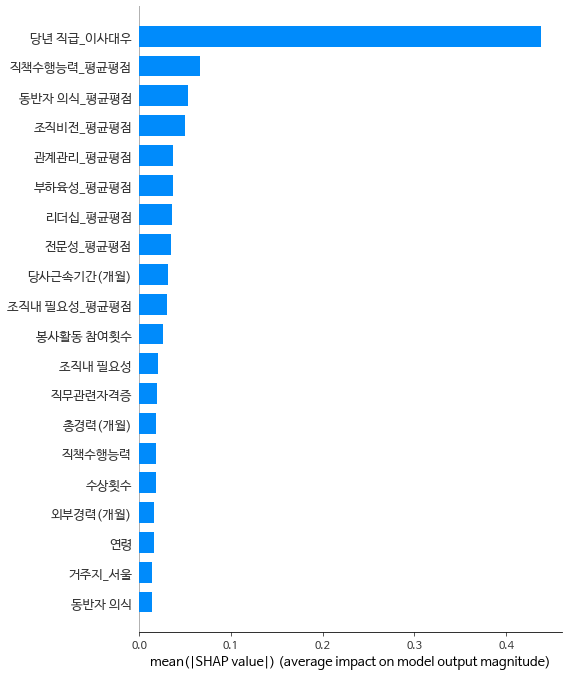

In [ ]:
explainer_1 = shap.TreeExplainer(model_rf_1, X_train_f) 
shap_values_1 = explainer_1.shap_values(X_test_f, check_additivity=False) 
shap.initjs()
shap.summary_plot(shap_values_1, X_test_f, plot_type = "bar")

In [ ]:
importances_1 = np.absolute(shap_values_1).sum(axis=0) / shap_values_1.shape[0]
feature_importance_1 = pd.Series(importances_1 / np.sum(importances_1))
feature_importance_1.index = X_train_f.columns

In [ ]:
# 수정
numerical = ['연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수',
       '금년 평균 교육점수', '전문성_평균평점', '리더십_평균평점', '부하육성_평균평점', '관계관리_평균평점',
       '조직비전_평균평점', '직책수행능력_평균평점', '조직내 필요성_평균평점', '동반자 의식_평균평점', '직책수행능력',
       '조직내 필요성', '동반자 의식']
categorical = ['학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부', '성별']
fe_list_1 = list(feature_importance_1.index)

In [ ]:
cat_imp_1 = []
for name in categorical : 
  sum = 0
  for i in range (len(fe_list_1)) : 
    if name in fe_list_1[i] :
      sum += feature_importance_1[i]
  cat_imp_1.append(sum)

In [ ]:
cat_fe_1 = pd.Series(cat_imp_1)
cat_fe_1.index = categorical

In [ ]:
nu_fe_1 = feature_importance_1[numerical]

In [ ]:
result_fe_1 = pd.concat([nu_fe_1, cat_fe_1])

In [ ]:
# 수정 1130
for name in result_fe_1.index.drop(['당년 직급']).tolist() : 
  result_fe_1[name] += result_fe_1['당년 직급']*0.95/(len(result_fe_1))

value = result_fe_1['당년 직급']*0.95/(len(result_fe_1))
result_fe_1['당년 직급'] = result_fe_1['당년 직급']*0.05 + value

###
result_fe_1['징계횟수'] = result_fe_1['수상횟수']
###

fe_dict_1 = result_fe_1.to_dict()

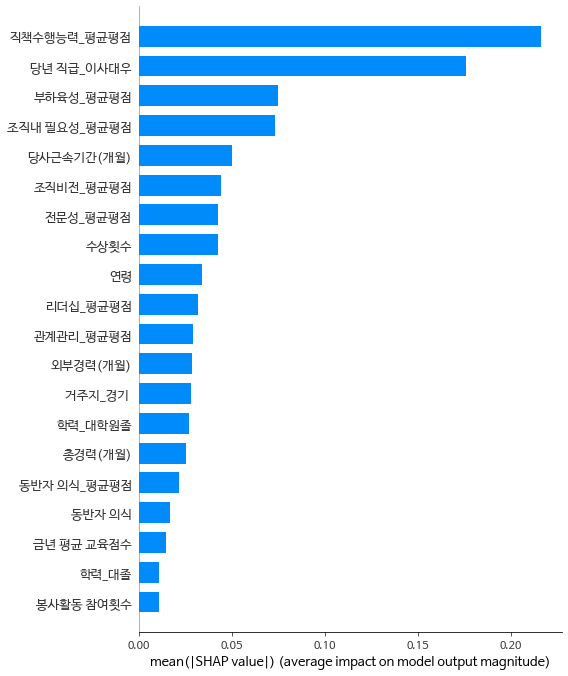

In [ ]:
explainer_2 = shap.TreeExplainer(model_rf_2, X_train_s) 
shap_values_2 = explainer_2.shap_values(X_test_s, check_additivity=False) 
shap.initjs()
shap.summary_plot(shap_values_2, X_test_s, plot_type = "bar")

In [ ]:
importances_2 = np.absolute(shap_values_2).sum(axis=0) / shap_values_2.shape[0]
feature_importance_2 = pd.Series(importances_2 / np.sum(importances_2))
feature_importance_2.index = X_train_s.columns

In [ ]:
fe_list_2 = list(feature_importance_2.index)

In [ ]:
cat_imp_2 = []
for name in categorical : 
  sum = 0
  for i in range (len(fe_list_2)) : 
    if name in fe_list_2[i] :
      sum += feature_importance_2[i]
  cat_imp_2.append(sum)

In [ ]:
cat_fe_2 = pd.Series(cat_imp_2)
cat_fe_2.index = categorical

In [ ]:
nu_fe_2 = feature_importance_2[numerical]

In [ ]:
result_fe_2 = pd.concat([nu_fe_2, cat_fe_2])

In [ ]:
# 수정 1130

result_fe_2['셀 참여횟수'] += result_fe_2['당사근속기간(개월)']*0.2
result_fe_2['봉사활동 참여횟수'] += result_fe_2['거주지']*0.1

result_fe_2['당사근속기간(개월)'] = result_fe_2['당사근속기간(개월)']*0.8
result_fe_2['거주지'] = result_fe_2['거주지']*0.9

for name in result_fe_2.index.drop(['당년 직급']).tolist() : 
  result_fe_2[name] += result_fe_2['당년 직급']*0.95/(len(result_fe_2))

value = result_fe_2['당년 직급']*0.95/(len(result_fe_2))
result_fe_2['당년 직급'] = result_fe_2['당년 직급']*0.05 + value

###
result_fe_2['징계횟수'] = result_fe_2['수상횟수']
###

fe_dict_2 = result_fe_2.to_dict()

In [ ]:
missing_rate = {}
feature_data = train_data_count[['당년 직급', '성별', '연령', '당사근속기간(개월)', '외부경력(개월)', '총경력(개월)', '입사경로', '학력', '전공',
       '거주지', '셀 참여횟수', '봉사활동 참여횟수', '직무관련자격증', '수상횟수', '금년 평균 교육점수', '금년 교육이수 여부', '전문성_평균평점', '리더십_평균평점', '부하육성_평균평점', '관계관리_평균평점',
       '조직비전_평균평점', '직책수행능력_평균평점', '조직내 필요성_평균평점', '동반자 의식_평균평점', '직책수행능력',
       '조직내 필요성', '동반자 의식']].reset_index(drop=True)

for name in feature_data.columns.tolist() : 
  cnt = 0
  for i in range(len(feature_data)) : 
    if feature_data[name].isnull()[i] == True : 
      cnt+=1
    elif feature_data[name][i]=='미입사' : 
      cnt+=1
    elif feature_data[name][i]=='미평가' : 
      cnt+=1
  missing_rate[name] = cnt/len(feature_data)

In [ ]:
missing_rate_cnt = {}
for name in feature_data.columns.tolist() : 
  cnt = 0
  for i in range(len(feature_data)) : 
    if feature_data[name].isnull()[i] == True : 
      cnt+=1
    elif feature_data[name][i]=='미입사' : 
      cnt+=1
    elif feature_data[name][i]=='미평가' : 
      cnt+=1
  missing_rate_cnt[name] = cnt

missing_rate_cnt['all'] = len(feature_data)       

In [ ]:
main_dict_1 = {}
main_dict_1['feature importance'] = fe_dict_1
main_dict_1['trainset_size'] = len(X_train)
main_dict_1['testset_size'] = len(X_test)
main_dict_1['total_size'] = len(X_train)+len(X_test)
main_dict_1['last_train_date'] = str(now)
main_dict_1['metrics'] = metrics_dict_1
main_dict_1['algorithm others'] = opt_dict_1

In [ ]:
json_file = json.dumps(main_dict_1)

In [ ]:
file_path_1 = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/대상자_역량평가등급.json'

In [ ]:
with open(file_path_1, 'w', encoding='utf-8') as file:
    file.write(json.dumps(main_dict_1, ensure_ascii=False))

In [ ]:
main_dict_2 = {}
main_dict_2['feature importance'] = fe_dict_2
main_dict_2['trainset_size'] = len(X_train)
main_dict_2['testset_size'] = len(X_test)
main_dict_2['total_size'] = len(X_train)+len(X_test)
main_dict_2['last_train_date'] = str(now)
main_dict_2['metrics'] = metrics_dict_2
main_dict_2['algorithm others'] = opt_dict_2

In [ ]:
json_file = json.dumps(main_dict_2)

In [ ]:
file_path_2 = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/대상자_업적평가등급.json'

In [ ]:
with open(file_path_2, 'w', encoding='utf-8') as file:
    file.write(json.dumps(main_dict_2, ensure_ascii=False))

In [ ]:
file_path_3 = '/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/output/missing_rate_다면평가.json'

In [ ]:
with open(file_path_3, 'w', encoding='utf-8') as file:
    file.write(json.dumps(missing_rate_cnt, ensure_ascii=False))

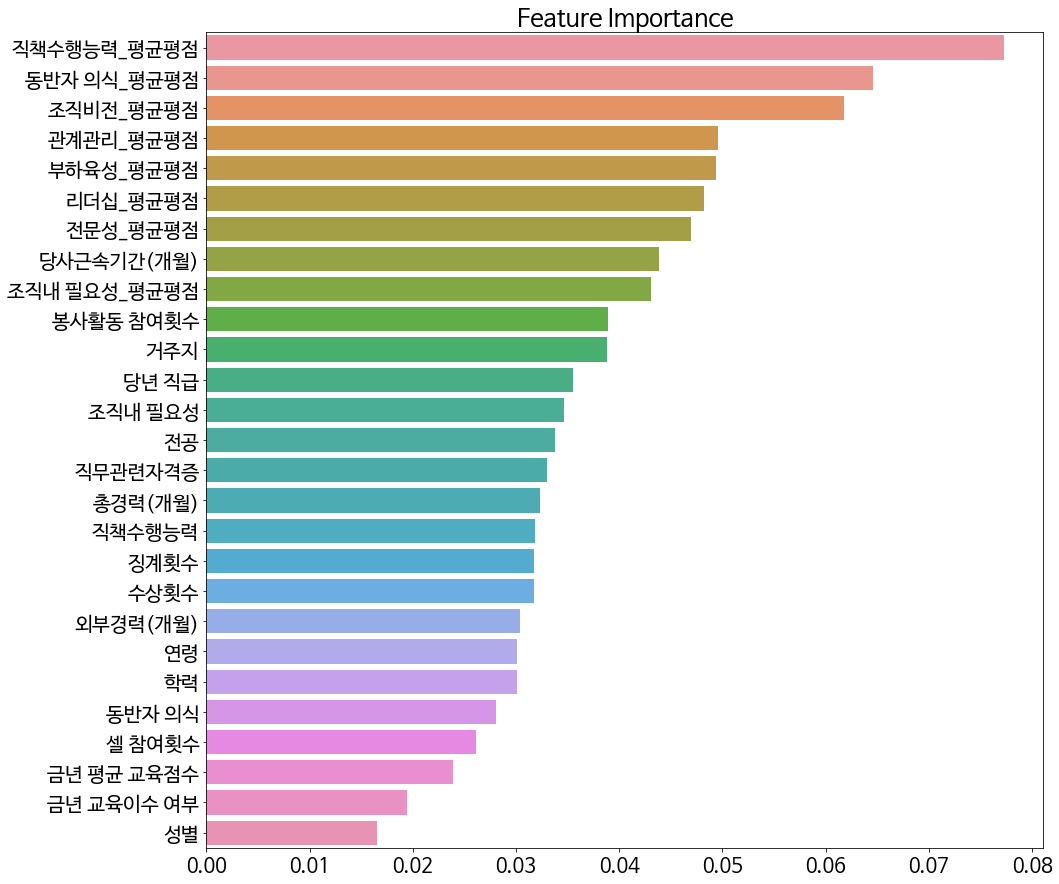

In [ ]:
import seaborn as sns

ft_importance = result_fe_1.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=20)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

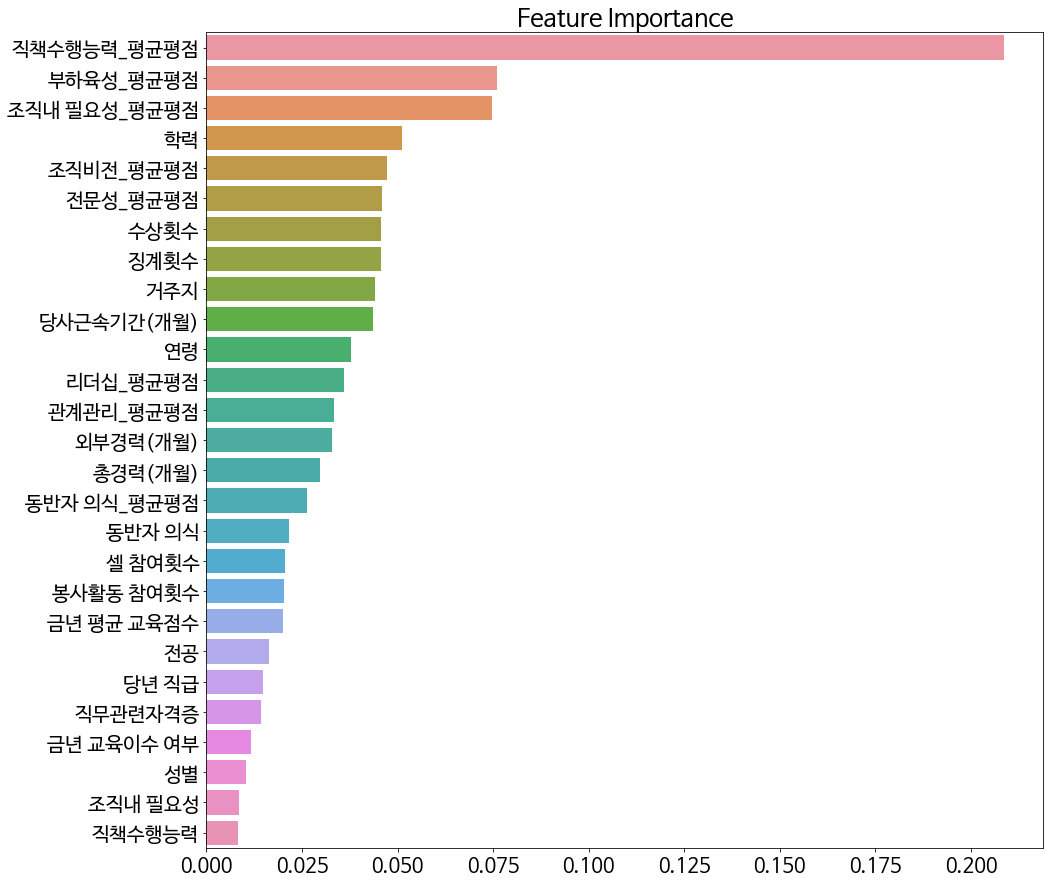

In [ ]:
import seaborn as sns

ft_importance = result_fe_2.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15,15))
plt.rc('font', size=20)  
plt.title('Feature Importance')
sns.barplot(x=ft_importance, y=ft_importance.index)
plt.show()

inference

In [ ]:
# 봉사활동 전처리 추가
inf_data['셀 참여횟수'] = inf_data['셀 참여횟수'].fillna(0)
inf_data['봉사활동 참여횟수'] = inf_data['봉사활동 참여횟수'].fillna(0)
inf_data['금년 평균 교육점수'] = inf_data['금년 평균 교육점수'].replace('미신청', 0)
inf_data = inf_data.drop(['성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책'], axis=1)

In [ ]:
# 수정
inf_x = pd.get_dummies(inf_data.drop(['사번'], axis=1), columns=['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부'], drop_first=True)
inf_x['금년 교육이수 여부_Yes'] = 0
inf_x = inf_x[X_train.columns]

In [ ]:
# 수정
predictions_la = model_rf_1.predict(inf_x)
predictions_xgb = model_rf_2.predict(inf_x)

In [ ]:
# 역량 30 50 20 %
# 업적 32 47 21 %
result = pd.DataFrame(columns=['역량평가등급', '업적평가등급'])
result['역량평가등급'] = predictions_la
result['업적평가등급'] = predictions_xgb

a_grade_f = result['역량평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*0.3-1)]
c_grade_f = result['역량평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*(1-0.2))]
a_grade_s = result['업적평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*0.32-1)]
c_grade_s = result['업적평가등급'].sort_values(ascending=False).reset_index(drop=True)[round(len(result)*(1-0.21))]

grade_f = []
grade_s = []

for i in range(len(result)) : 
  if result['역량평가등급'][i] >= a_grade_f : 
    grade_f.append("A")
  elif result['역량평가등급'][i] <= c_grade_f : 
    grade_f.append("C")
  else : 
    grade_f.append("B")
  
  if result['업적평가등급'][i] >= a_grade_s : 
    grade_s.append("A")
  elif result['업적평가등급'][i] <= c_grade_s : 
    grade_s.append("C")
  else : 
    grade_s.append("B")

result['역량평가등급_grade'] = grade_f
result['업적평가등급_grade'] = grade_s

In [ ]:
# 추가
final_result_1 = inf_data.copy()
final_result_1.drop(['역량평가등급', '업적평가등급'], axis=1, inplace=True)
final_result_2 = inf_data.copy()
final_result_2.drop(['역량평가등급', '업적평가등급'], axis=1, inplace=True)
final_result_1['역량평가등급'] = result['역량평가등급']
final_result_1['역량평가등급_grade'] = result['역량평가등급_grade']
final_result_2['업적평가등급'] = result['업적평가등급']
final_result_2['업적평가등급_grade'] = result['업적평가등급_grade']

In [ ]:
private = inf[['사번', '성명', '연락처', '이메일', '생년월일', '본부', '실', '팀', '직무', '직급', '현 직급 근속기간(연)', '직책']]
final_result_1.drop(['사번'], axis=1, inplace=True)
final_result_1 = pd.concat([private, final_result_1], axis=1)
final_result_2.drop(['사번'], axis=1, inplace=True)
final_result_2 = pd.concat([private, final_result_2], axis=1)

In [ ]:
# 추가
final_result_1['2019_역량평가등급'] = inf['2019_역량평가등급']
final_result_1['2020_역량평가등급'] = inf['2020_역량평가등급']
final_result_1['2021_역량평가등급'] = inf['역량평가등급']

final_result_2['2019_업적평가등급'] = inf['2019_업적평가등급']
final_result_2['2020_업적평가등급'] = inf['2020_업적평가등급']
final_result_2['2021_업적평가등급'] = inf['업적평가등급']

In [ ]:
# 추가
final_result_1['금년 평균 교육점수'] = inf['금년 평균 교육점수']
final_result_2['금년 평균 교육점수'] = inf['금년 평균 교육점수']

In [ ]:
# 수정 1107
final_result_1.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)
final_result_2.replace({'직급' : ['업무지원역', '기획역']}, '기타', inplace=True)

In [ ]:
# 수정 1116
attrition = ['정희진', '박영민', '강도이', '박상완']
attrition_idx = []
for i in range(len(final_result_1)) : 
 if final_result_1['성명'][i] in attrition : 
   attrition_idx.append(i)

final_result_1.drop(attrition_idx, inplace=True)
final_result_2.drop(attrition_idx, inplace=True)

In [ ]:
# 추가 1129
punish_list = ['B1210011', 'B1110035', 'B1110036', 'B1110058', 'B1110077', 'B1510023', 'B1510062', 'B1210021', 'B1210076']
punish_data = []
for i in range(len(final_result_1)) : 
  if final_result_1['사번'][i] in punish_list : 
    punish_data.append(1)
  elif final_result_1['사번'][i] == 'B1310064' : 
    punish_data.append(2)
  else : 
    punish_data.append(0)

In [ ]:
# 추가 1129
for i in range(len(punish_data)) : 
  if punish_data[i] == 1 : 
    final_result_1['역량평가등급'][i] = final_result_1['역량평가등급'][i]*(1-0.04)
    final_result_2['업적평가등급'][i] = final_result_2['업적평가등급'][i]*(1-0.04)
  if punish_data[i] == 2 : 
    final_result_1['역량평가등급'][i] = final_result_1['역량평가등급'][i]*(1-0.08)
    final_result_2['업적평가등급'][i] = final_result_2['업적평가등급'][i]*(1-0.08)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
final_result_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_대상_역량평가등급.csv', encoding='utf-8-sig', index=False)
final_result_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/성과관리_대상_업적평가등급.csv', encoding='utf-8-sig', index=False)

In [ ]:
shap_values_inf_1 = explainer_1.shap_values(inf_x)

pos_max_1 = shap_values_inf_1.max(axis=0)
neg_max_1 = shap_values_inf_1.min(axis=0)
new_list_1 = []
for row in shap_values_inf_1:
  temp = []
  for ele, pos, neg in zip(row, pos_max_1, neg_max_1):
    if ele >= 0:
      if pos == 0: #수정
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list_1.append(temp)

feature_weight_1 = pd.DataFrame(new_list_1, index = pd.RangeIndex(len(shap_values_inf_1)), columns = inf_x.columns)
feature_weight_1 = feature_weight_1.fillna(0)

In [ ]:
feature_weight_1.mean()

연령                0.084370
당사근속기간(개월)        0.006561
외부경력(개월)          0.107613
총경력(개월)           0.070303
셀 참여횟수           -0.029543
봉사활동 참여횟수        -0.170396
직무관련자격증          -0.207671
수상횟수              0.381053
금년 평균 교육점수        0.300427
전문성_평균평점          0.300231
리더십_평균평점          0.239171
부하육성_평균평점         0.111793
관계관리_평균평점         0.246765
조직비전_평균평점         0.420482
직책수행능력_평균평점       0.386364
조직내 필요성_평균평점      0.149589
동반자 의식_평균평점      -0.183624
직책수행능력           -0.374672
조직내 필요성           0.043892
동반자 의식           -0.183394
성별_여자            -0.522928
학력_대졸            -0.105855
학력_대학원졸          -0.335498
학력_전졸            -0.021704
전공_공학계열           0.219840
전공_사회계열          -0.087435
전공_자연계열          -0.325670
당년 직급_부장          0.021239
당년 직급_이사대우       -0.349936
당년 직급_차장          0.066726
거주지_경기           -0.184902
거주지_광주            0.239335
거주지_대구           -0.642468
거주지_대전            0.450764
거주지_부산           -0.018868
거주지_서울           -0.055329
거주지_인천            0.364960
금

In [ ]:
categorical_feature = ['성별', '입사경로', '학력', '전공', '당년 직급', '거주지', '금년 교육이수 여부']
cate_main_1 = []

for i in range(len(feature_weight_1)) :
  temp_1 = []
  for name in categorical_feature : 
    temp_2 = []
    for j in range (len(feature_weight_1.columns.tolist())) : 
      if name in feature_weight_1.columns.tolist()[j] : 
        real_name = feature_weight_1.columns.tolist()[j]
        temp_2.append(feature_weight_1[real_name][i])
    data_sum = np.sum(temp_2)
    temp_1.append(data_sum)
  cate_main_1.append(temp_1)

In [ ]:
ttt_f = pd.DataFrame(cate_main_1, columns=categorical_feature)

feature_weight_1.drop(['학력_대졸', '학력_대학원졸', '학력_전졸', '전공_공학계열', '전공_사회계열',
       '전공_자연계열', '당년 직급_부장', '당년 직급_이사대우', '당년 직급_차장', '거주지_경기 ', '거주지_광주',
       '거주지_대구', '거주지_대전', '거주지_부산', '거주지_서울', '거주지_인천', '금년 교육이수 여부_Yes',
       '금년 교육이수 여부_미신청', '성별_여자'], axis=1, inplace=True)
feature_weight_1 = pd.concat([feature_weight_1, ttt_f], axis=1)

In [ ]:
mm = MinMaxScaler(feature_range=(-1, 1))

for i in range (len(feature_weight_1.max())) : 
  if feature_weight_1.max()[i] > 1 : 
    feature_name = feature_weight_1.max().index[i]
    scaling = mm.fit_transform(feature_weight_1[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_1)) : 
      feature_weight_1[feature_name][j] = scaling[j][0]

for i in range (len(feature_weight_1.min())) : 
  if feature_weight_1.min()[i] < -1 : 
    feature_name = feature_weight_1.min().index[i]
    scaling = mm.fit_transform(feature_weight_1[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_1)) : 
      feature_weight_1[feature_name][j] = scaling[j][0]

In [ ]:
feature_weight_1.insert(0, '사번', inf_data['사번'].tolist())

In [ ]:
shap_values_inf_2 = explainer_2.shap_values(inf_x)

pos_max_2 = shap_values_inf_2.max(axis=0)
neg_max_2 = shap_values_inf_2.min(axis=0)
new_list_2 = []
for row in shap_values_inf_2:
  temp = []
  for ele, pos, neg in zip(row, pos_max_2, neg_max_2):
    if ele >= 0:
      if pos == 0: #수정
        temp.append(0)
      else:
        temp.append(ele/pos)
    else:
      if neg == 0:
        temp.append(0)
      else:
        temp.append(-ele/neg)
  new_list_2.append(temp)

feature_weight_2 = pd.DataFrame(new_list_2, index = pd.RangeIndex(len(shap_values_inf_2)), columns = inf_x.columns)
feature_weight_2 = feature_weight_2.fillna(0)

In [ ]:
feature_weight_2.mean()

연령                0.244655
당사근속기간(개월)        0.139330
외부경력(개월)          0.101566
총경력(개월)           0.107953
셀 참여횟수           -0.016183
봉사활동 참여횟수         0.172883
직무관련자격증           0.271351
수상횟수             -0.055056
금년 평균 교육점수       -0.010770
전문성_평균평점          0.178323
리더십_평균평점         -0.002167
부하육성_평균평점         0.168817
관계관리_평균평점        -0.062351
조직비전_평균평점        -0.060500
직책수행능력_평균평점       0.342610
조직내 필요성_평균평점      0.248676
동반자 의식_평균평점       0.060597
직책수행능력           -0.343131
조직내 필요성          -0.025657
동반자 의식            0.208583
성별_여자            -0.549015
학력_대졸            -0.057570
학력_대학원졸          -0.175168
학력_전졸             0.427629
전공_공학계열           0.093658
전공_사회계열          -0.052937
전공_자연계열          -0.026848
당년 직급_부장          0.053340
당년 직급_이사대우       -0.295133
당년 직급_차장         -0.144587
거주지_경기           -0.251656
거주지_광주            0.431358
거주지_대구            0.474710
거주지_대전            0.513886
거주지_부산            0.018868
거주지_서울            0.099719
거주지_인천            0.554285
금

In [ ]:
cate_main_2 = []

for i in range(len(feature_weight_2)) :
  temp_1 = []
  for name in categorical_feature : 
    temp_2 = []
    for j in range (len(feature_weight_2.columns.tolist())) : 
      if name in feature_weight_2.columns.tolist()[j] : 
        real_name = feature_weight_2.columns.tolist()[j]
        temp_2.append(feature_weight_2[real_name][i])
    data_sum = np.sum(temp_2)
    temp_1.append(data_sum)
  cate_main_2.append(temp_1)

In [ ]:
ttt_s = pd.DataFrame(cate_main_2, columns=categorical_feature)

feature_weight_2.drop(['학력_대졸', '학력_대학원졸', '학력_전졸', '전공_공학계열', '전공_사회계열',
       '전공_자연계열', '당년 직급_부장', '당년 직급_이사대우', '당년 직급_차장', '거주지_경기 ', '거주지_광주',
       '거주지_대구', '거주지_대전', '거주지_부산', '거주지_서울', '거주지_인천', '금년 교육이수 여부_Yes',
       '금년 교육이수 여부_미신청', '성별_여자'], axis=1, inplace=True)
feature_weight_2 = pd.concat([feature_weight_2, ttt_s], axis=1)

In [ ]:
for i in range (len(feature_weight_2.max())) : 
  if feature_weight_2.max()[i] > 1 : 
    feature_name = feature_weight_2.max().index[i]
    scaling = mm.fit_transform(feature_weight_2[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_2)) : 
      feature_weight_2[feature_name][j] = scaling[j][0]

for i in range (len(feature_weight_2.min())) : 
  if feature_weight_2.min()[i] < -1 : 
    feature_name = feature_weight_2.min().index[i]
    scaling = mm.fit_transform(feature_weight_2[feature_name].values.reshape(-1,1))
    for j in range (len(feature_weight_2)) : 
      feature_weight_2[feature_name][j] = scaling[j][0]

In [ ]:
feature_weight_2.insert(0, '사번', inf_data['사번'].tolist())

In [ ]:
# 수정 1103
feature_weight_1['당년 직급'] = feature_weight_1['당년 직급']*0.05
feature_weight_2['당년 직급'] = feature_weight_2['당년 직급']*0.05

feature_weight_2['당사근속기간(개월)'] = feature_weight_2['당사근속기간(개월)']*0.8
feature_weight_2['거주지'] = feature_weight_2['거주지']*0.9

In [ ]:
feature_weight_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/feature_weight_대상자_역량.csv', encoding='utf-8-sig', index=False)
feature_weight_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/feature_weight_대상자_업적.csv', encoding='utf-8-sig', index=False)

In [ ]:
train_prediction_1 = pd.DataFrame(columns=['사번', 'train_predict', 'train_label'])
train_prediction_2 = pd.DataFrame(columns=['사번', 'train_predict', 'train_label'])

In [ ]:
train_prediction_1['사번'] = train_name_f.reset_index(drop=True)
train_prediction_2['사번'] = train_name_s.reset_index(drop=True)
train_prediction_1['train_predict'] = y_train_f.reset_index(drop=True)
train_prediction_2['train_predict'] = y_train_s.reset_index(drop=True)

In [ ]:
train_prediction_1['train_label'] = train_prediction_1['train_predict'].replace({5 : "S", 4 : "A", 3 : "B", 2 : "C", 1 : "D"})
train_prediction_2['train_label'] = train_prediction_2['train_predict'].replace({5 : "S", 4 : "A", 3 : "B", 2 : "C", 1 : "D"})

In [ ]:
train_prediction_1.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/train_prediction_대상자_역량.csv', encoding='utf-8-sig', index=False)
train_prediction_2.to_csv('/content/drive/My Drive/Colab Notebooks/NH농협캐피탈/성과관리/train_prediction_대상자_업적.csv', encoding='utf-8-sig', index=False)

In [ ]:
qwer = final_result_1.copy()
qqqq = qwer[numerical]
qqqq['역량평가등급'] = qwer['역량평가등급']
qqqq = qqqq.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
qqqq.replace('미신청', 0, inplace=True)
qqqq.replace('미입사', 0, inplace=True)

In [ ]:
qqqq = qqqq.astype('float')

In [ ]:
ffff= qqqq.corr(method='pearson')

In [ ]:
df = pd.DataFrame(ffff['역량평가등급'].sort_values(ascending=False), columns=['역량평가등급'])
df.style.background_gradient(cmap='viridis')

,역량평가등급
역량평가등급,1.000000
총경력(개월),0.464875
연령,0.401226
조직비전_평균평점,0.309422
외부경력(개월),0.305480
직책수행능력_평균평점,0.283694
전문성_평균평점,0.271046
부하육성_평균평점,0.232899
리더십_평균평점,0.227236
조직내 필요성_평균평점,0.225214


In [ ]:
qwer = final_result_2.copy()
qqqq = qwer[numerical]
qqqq['업적평가등급'] = qwer['업적평가등급']
qqqq = qqqq.reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
qqqq.replace('미신청', 0, inplace=True)
qqqq.replace('미입사', 0, inplace=True)

In [ ]:
qqqq = qqqq.astype('float')

In [ ]:
ffff= qqqq.corr(method='pearson')

In [ ]:
df = pd.DataFrame(ffff['업적평가등급'].sort_values(ascending=False), columns=['업적평가등급'])
df.style.background_gradient(cmap='viridis')

,업적평가등급
업적평가등급,1.000000
총경력(개월),0.329655
동반자 의식_평균평점,0.315485
연령,0.314152
부하육성_평균평점,0.287286
리더십_평균평점,0.268048
당사근속기간(개월),0.266085
조직비전_평균평점,0.265373
관계관리_평균평점,0.244718
직책수행능력_평균평점,0.240213


In [ ]:
final_result_1.loc[final_result_1['거주지']=='대전']

,사번,성명,연락처,이메일,생년월일,본부,실,팀,직무,직급,...,조직내 필요성_평균평점,동반자 의식_평균평점,직책수행능력,조직내 필요성,동반자 의식,역량평가등급,역량평가등급_grade,2019_역량평가등급,2020_역량평가등급,2021_역량평가등급
19,B1110029,장훈,010-5435-8867,devotion96@nhcapital.co.kr,1978-02-05,리테일금융본부,리테일금융실,리테일영업지원팀,부서총괄,부장,...,3.0,3.0,0,1,1,3.501762,B,C,B,A
36,B1210076,이경섭,010-3425-2596,kslee12@nhcapital.co.kr,1975-10-31,리테일금융본부,리테일영업1센터,대전지점,부서총괄,부장,...,3.0,3.0,0,0,0,3.477737,B,A,C,A
